In [1]:
from libraries import *
from modelling_qsar import QSAR
from qsar_evidence_combinator import QSAR_Single_Evidence, QSAR_Evidence_Combinator

### Import data for modelling

In [2]:
pradeep_ames = r"F:\My Drive\UPF\projects\dst\dst_evidence_combinator\examples\data\ames_pradeep_train.sdf"
hansen_ames = r"F:\My Drive\UPF\projects\dst\dst_evidence_combinator\examples\data\ames_hansen_train.sdf"
hakura_ames = r"F:\My Drive\UPF\projects\dst\dst_evidence_combinator\examples\data\ames_hakura_train.sdf"

ames_test = r"F:\My Drive\UPF\projects\dst\dst_evidence_combinator\examples\data\ames_test.sdf"

In [3]:
t = PandasTools.LoadSDF(os.path.join(RDConfig.RDDataDir, ames_test),molColName='molecule', includeFingerprints=True)

### Build models

In [4]:
from sklearn.ensemble import RandomForestClassifier

# initiate class
Ames_RF = QSAR(hansen_ames)

# compute descriptors for modelling
Ames_RF.compute_descriptors('MolecularDescriptors')

# build model 
Ames_RF.model(model=RandomForestClassifier(random_state=28, n_estimators = 700,min_samples_split=10,min_samples_leaf=3, max_features='sqrt', max_depth=100, bootstrap=False))

# return reliability with prior
Ames_RF_reliability = Ames_RF.get_performance(prior=0.35)

# return prediction for the test
Ames_RF_prediction = Ames_RF.predict_proba(ames_test)

INFO - Computing RDKit descriptors...
INFO - Building model...
INFO - Returning updated model performance considering prior probability...
INFO - Computing RDKit descriptors...
INFO - Running percent probability prediction for the test...


In [5]:
import xgboost as xgb

# initiate class
Ames_XGBOOST = QSAR(pradeep_ames)

# compute descriptors for modelling
Ames_XGBOOST.compute_descriptors('MorganFingerprints')

# build model 
Ames_XGBOOST.model(model=xgb.XGBClassifier(gamma = 0, learning_rate = 0.1, max_depth = 6, min_child_weigh = 1, n_estimators=100, verbosity = 0, silent=True,subsample=1, random_state = 28))

# return reliability with prior
Ames_XGBOOST_reliability = Ames_XGBOOST.get_performance(prior=0.4)

# return prediction for the test
Ames_XGBOOST_prediction = Ames_XGBOOST.predict_proba(ames_test)

INFO - computing RDKit Morgan fingerprint... with radius 2, size 2048 and features True
INFO - Building model...
INFO - Returning updated model performance considering prior probability...
INFO - computing RDKit Morgan fingerprint... with radius 2, size 2048 and features True
INFO - Running percent probability prediction for the test...


In [6]:
from sklearn import svm

Ames_SVM = QSAR(hakura_ames)

# compute descriptors for modelling
Ames_SVM.compute_descriptors('PhysioChemicalProperties')

# build model 
Ames_SVM.model(model=svm.SVC(C=100, kernel='rbf',gamma='auto', probability=True))

# return reliability with prior
Ames_SVM_reliability = Ames_SVM.get_performance()

# return prediction for the test
Ames_SVM_prediction = Ames_SVM.predict_proba(ames_test)

INFO - Computing RDKit properties...
INFO - Building model...
INFO - Returning model evaluation metrics ...
INFO - Computing RDKit properties...
INFO - Running percent probability prediction for the test...


### Single class objects

In [37]:
RF = QSAR_Single_Evidence(identifier= 'RF', prediction=Ames_RF_prediction, reliability=Ames_RF_reliability, relevance='certain')
XGBOOST = QSAR_Single_Evidence(identifier= 'XGBOOST', prediction=Ames_XGBOOST_prediction, reliability=Ames_XGBOOST_reliability,relevance='certain')
SVM = QSAR_Single_Evidence(identifier= 'SVM', prediction=Ames_SVM_prediction, reliability=Ames_SVM_reliability, weight = 3)

INFO - Processing evidence from model identified as "RF"...
INFO - Processing evidence from model identified as "XGBOOST"...
INFO - Processing evidence from model identified as "SVM"...


### Further examples for single class objects

In [8]:
RF.test(test_set=t)
RF.ids

0    13114-72-2
1       86-57-7
2      583-39-1
3     2185-92-4
4    32425-83-5
5       98-37-3
Name: ID, dtype: object

In [9]:
RF.qsar_show_components(selection='BPA')

Showing the basic probability assignments of provided evidence ...


,Negative,Uncertain,Positive
ID,,,
13114-72-2,0.566447,0.180929,0.252624
86-57-7,0.046414,0.319487,0.634099
583-39-1,0.631275,0.163656,0.205069
2185-92-4,0.094604,0.306647,0.598749
32425-83-5,0.293872,0.253554,0.452574
98-37-3,0.625373,0.165229,0.209398


In [10]:
RF.qsar_show_components(selection='BP')

Showing the belief and plausibility for outcomes associated with provided evidence...


,Belief (Negative),Plausibility (Negative),Belief (Positive),Plausibility (Positive)
ID,,,,
13114-72-2,0.566447,0.747376,0.252624,0.433553
86-57-7,0.046414,0.365901,0.634099,0.953586
583-39-1,0.631275,0.794931,0.205069,0.368725
2185-92-4,0.094604,0.401251,0.598749,0.905396
32425-83-5,0.293872,0.547426,0.452574,0.706128
98-37-3,0.625373,0.790602,0.209398,0.374627


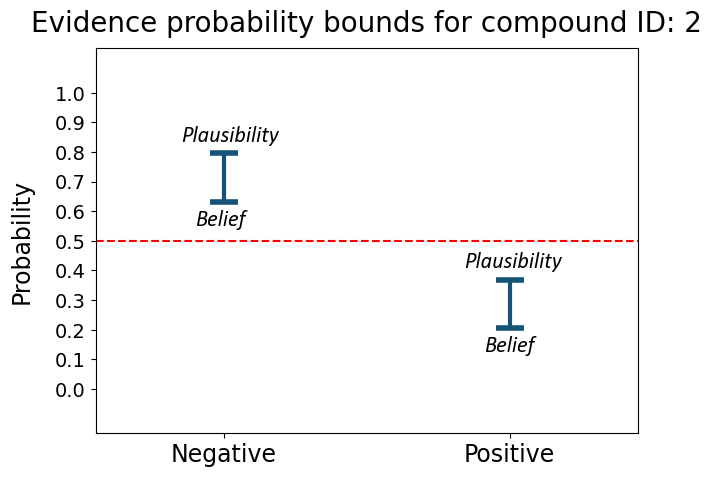

In [38]:
RF.qsar_visualise_single_evidence(compound = 2, visualise_threshold = 0.5)

### Multiple evidence class

In [29]:
Ames_models = QSAR_Evidence_Combinator('Ames mutagenicity')

INFO - QSAR Evidence Combinator initiated for the endpoint "Ames mutagenicity"...


In [30]:
Ames_models.add_evidence(RF)
Ames_models.add_evidence(XGBOOST)
Ames_models.add_evidence(SVM)

INFO - Adding evidence from QSAR model with identifier RF ...
INFO - Adding evidence from QSAR model with identifier XGBOOST ...
INFO - Adding evidence from QSAR model with identifier SVM ...


In [31]:
Ames_models.upload_test(test_set=t)

INFO - Test set defined...


In [32]:
Ames_models.combination(rule_selection=None, WoE=True)

INFO - Considering individual weights of evidence...
INFO - Computing ground probability masses...
INFO - Combining evidence...
INFO - No rule selected, combining evidence using all rules...


F:\My Drive\UPF\projects\dst\dst_evidence_combinator\combine\qsar_evidence_combinator.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_woe = df_woe.append([consider_weight]*(weight-1))
F:\My Drive\UPF\projects\dst\dst_evidence_combinator\combine\qsar_evidence_combinator.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_woe = df_woe.append([consider_weight]*(weight-1))
F:\My Drive\UPF\projects\dst\dst_evidence_combinator\combine\qsar_evidence_combinator.py:403: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_woe = df_woe.append([consider_weight]*(weight-1))
F:\My Drive\UPF\projects\dst\dst_evidence_combinator\combine\qsar_evidence_combinator.py:403: FutureWarning: The frame.append method is deprecated and wil

In [33]:
Ames_models.return_results(mol='583-39-1')

,Negative,Uncertain,Positive
RF,0.631275,0.163656,0.205069
XGBOOST,0.543617,0.210718,0.245665
SVM,0.483823,0.516177,0.000000
Dempster,0.962554,0.007674,0.029773
Yager,0.594901,0.386698,0.018401


INFO - Showing results for: 583-39-1


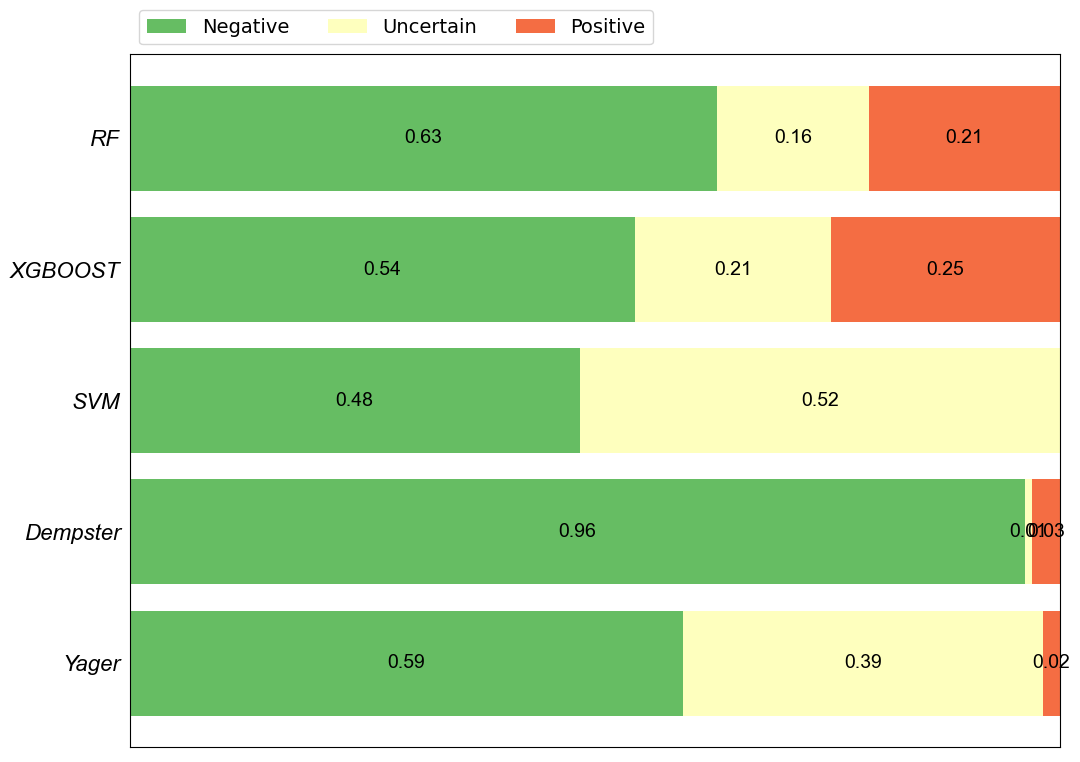

In [34]:
Ames_models.visualise(mol='583-39-1')

INFO - No rule selected for combination, automatically selected Dempster's rule.
INFO - Showing results for: 13114-72-2


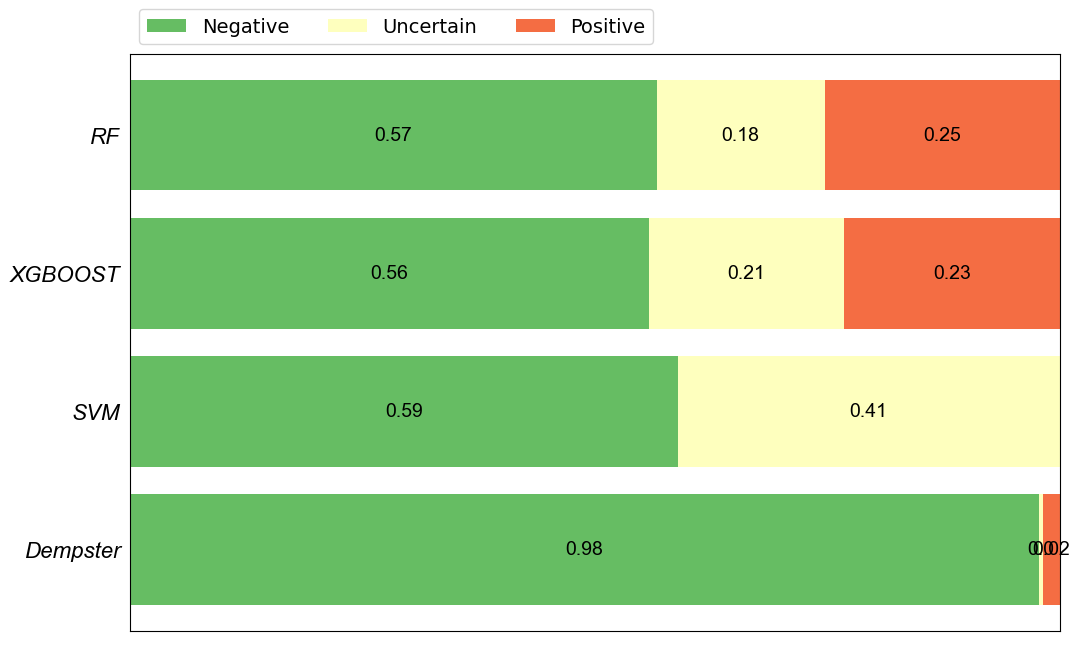

INFO - Showing results for: 86-57-7


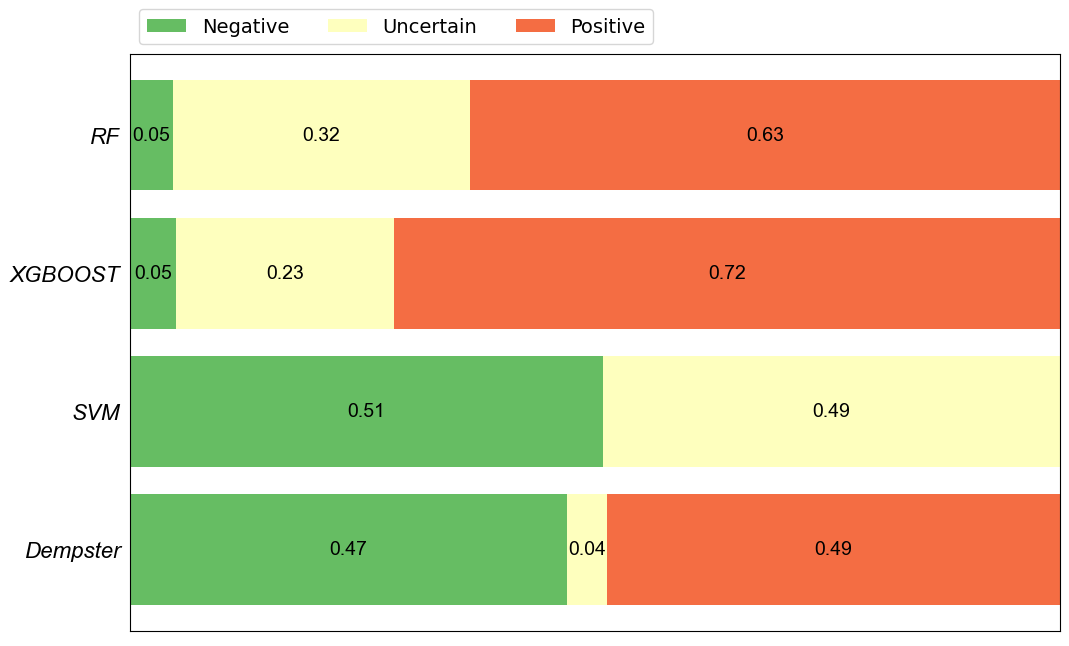

INFO - Showing results for: 583-39-1


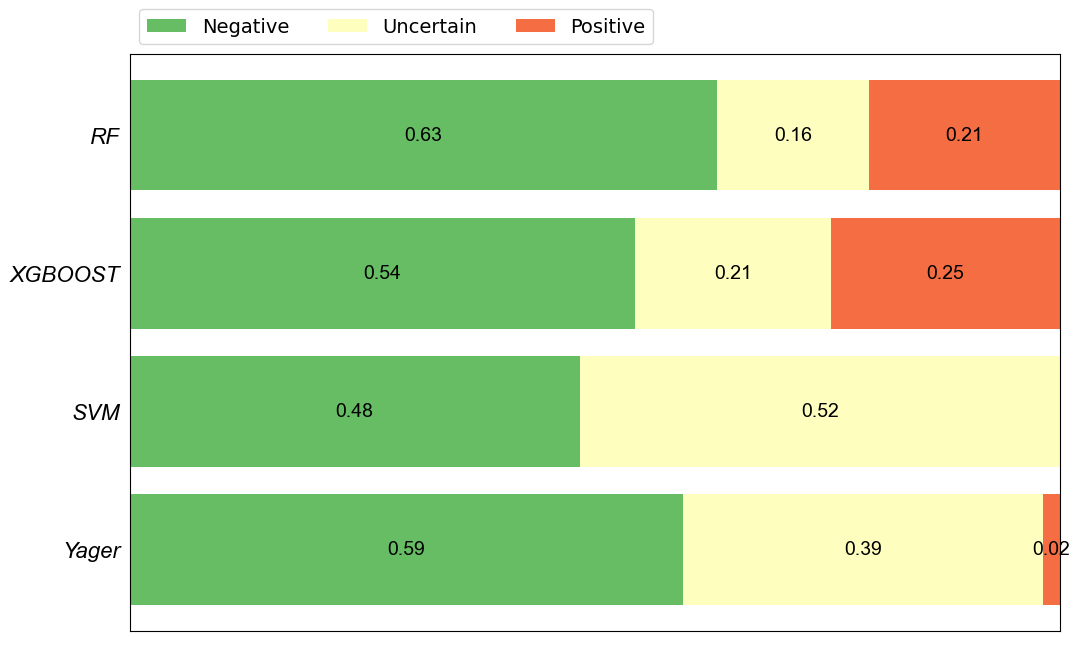

INFO - Showing results for: 2185-92-4


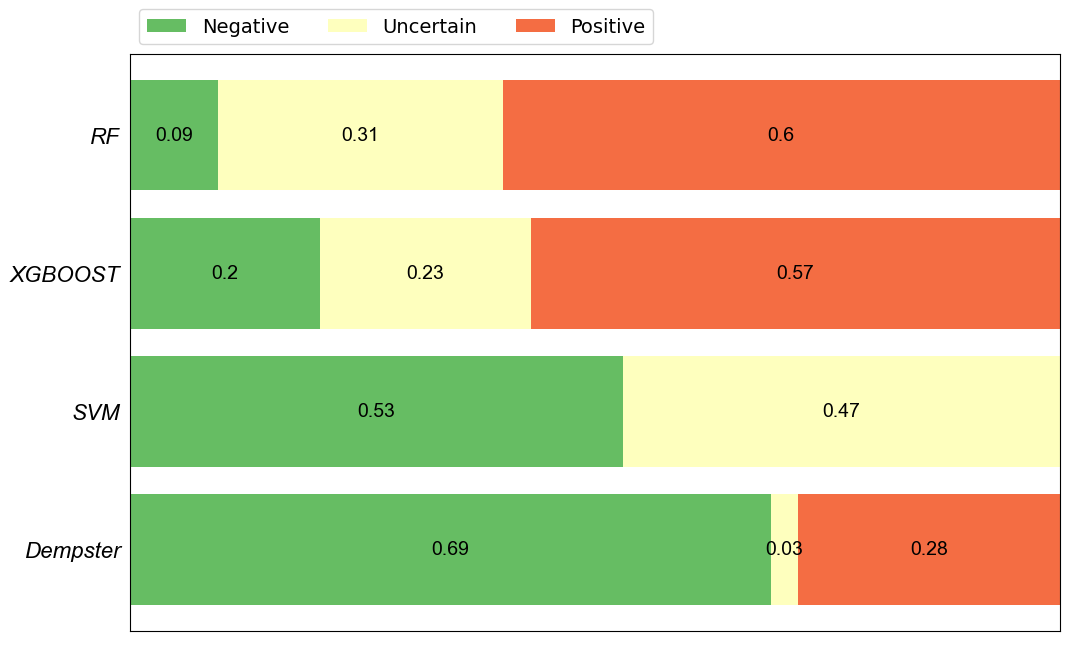

INFO - Showing results for: 32425-83-5


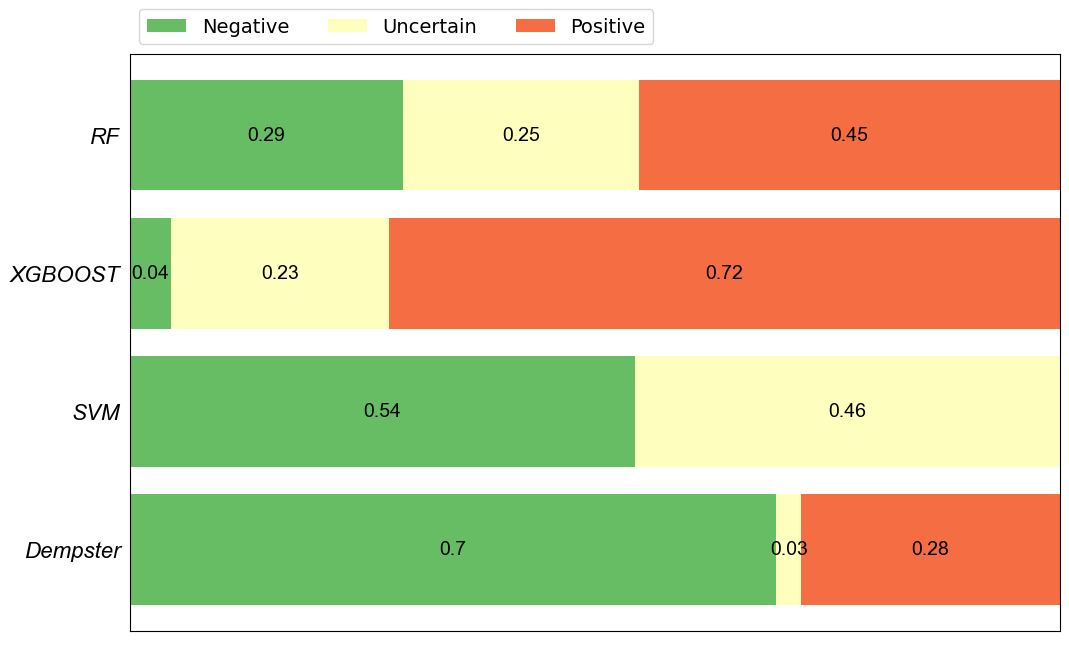

INFO - Showing results for: 98-37-3


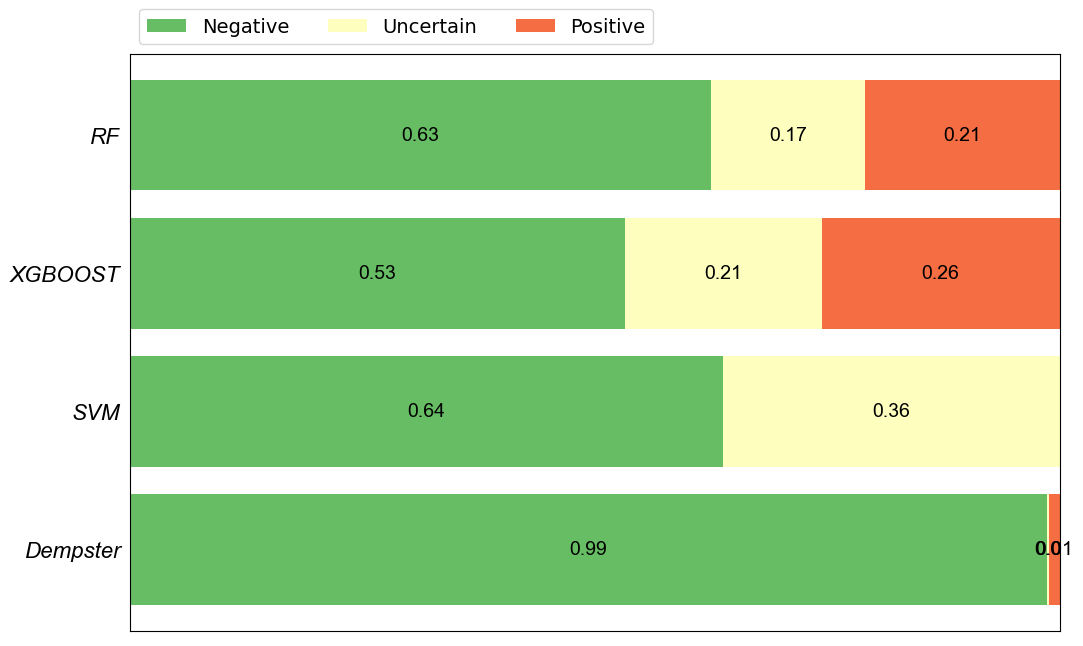

INFO - Decisions computed and stored for collected evidence!


In [35]:
Ames_models.decision_maker(visualise=True)